::: {.callout-note title="Summary"}

If parsing and validating the request significantly contributes to the processing time, there might be room to optimize your FastAPI REST API.
The key is to use directly Starlette at one or two spots and to leverage some of Pydantic's magic to accelerate validation.

:::

Part of [FastAPI](https://fastapi.tiangolo.com/)'s merit is how well it leverages other tools to serve its purpose.
FastAPI adds the layers it needs on top of them to deliver all the niceties that make the framework so popular these days.
Of course, one of them is right in the name: It's *fast*.
Such speed comes to a great extent from [Starlette](https://www.starlette.io/), a minimal web framework used by FastAPI under the hood and [Pydantic](https://docs.pydantic.dev/latest/), used for data validation, serialization, etc.

It turns out that sometimes we can tweak those tools directly (even inside of a FastAPI application) in order to make things go even faster. 
I will show a few pretty simple tricks to speed up your app without adding much complexity, provided we can compromise a bit of FastAPI's ergonomics in return.

::: {.callout-note title="Shout-Out"}

Most of what you're about to read I learnt in conversation with [Marcelo Trylesinski](https://github.com/Kludex) at Europython 2024.
He's deeply involved with all above mentioned projects and generously took some time to code and debug stuff with me.  
Thank you, Marcelo! 🧉

:::

# 🎬 A Simple Baseline

Let's create a little FastAPI app to demonstrate the optimizations.
Our fake app will receive a list of items, each item having a name and a price. 
For the sake of just doing some computation with the request content, our "microservice" will re-calculate the price for each item and return the list with new prices (just random changes).

Importantly, we want to validate both the input and the output data.
This is one of the niceties of FastAPI: By defining `response_model` and passing the type of the `request` argument, FastAPI will know what we want and will use them automatically.

::: {.callout-note title="Note"}

I will repeat my self a bit in the definitions of each app.
The idea is to have self-contained code in each case that will be written to a file to be run from there in the command line.

:::

In [ ]:
#| code-fold: true

import json
import requests

import numpy as np
import pandas as pd


def make_fake_payload(n):
    return {
        "items": [
            {"name": f"id_{i}", "price": i}
            for i in range(n)
        ]
    }
# Create fake payload for profiling
payload = make_fake_payload(10_000)

def do_request(payload, url):
    return requests.post(url, json=payload)

def print_times(timings):
    print("Mean:", np.mean(timings).round(3))
    print("P99:", np.percentile(timings, 99).round(3))

In [ ]:
%%writefile pricing.py

import random

# We will import this in all our apps
def reprice(items: list[dict]) -> list[dict]:
    """Simulate a reprice strategy"""
    return [
        {
            "name": item["name"],
            "price": round(item["price"] + random.random(), 2)
        }
        for item in items
    ]

Overwriting pricing.py


In [ ]:
%%writefile app.py

import numpy as np
from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn

from pricing import reprice

# Define custom Request and Response Pydantic model
class Item(BaseModel):
    name: str
    price: float

class CustomRequest(BaseModel):
    items: list[Item]

class CustomResponse(BaseModel):
    items: list[Item]

app = FastAPI()

@app.post("/pricing", response_model=CustomResponse)
async def fix_price(request: CustomRequest):
    return {"items": reprice(request.model_dump()["items"])}

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000, log_level="error")

Overwriting app.py


We launch the app in the background with

```bash
python app.py
```

so that we can timeit from here:

In [ ]:
times = %timeit -o -r 20 do_request(payload, "http://0.0.0.0:8000/pricing")

69.9 ms ± 3.28 ms per loop (mean ± std. dev. of 20 runs, 10 loops each)


In [ ]:
print_times(times.timings)

Mean: 0.07
P99: 0.08


That's our baseline.  
We can do better.

# 🎩 Bring Starlette and Pydantic to the Front
We will read the bytes directly from the request body and build the Pydantic model ourselves.
The reason for that is that Pydantic can directly parse the bytes into a Pydantic model, thus skipping the deserialization into a Python dict first.
We will also let Pydantic serialize the model and wrap it as a Starlette's response.

In [ ]:
%%writefile app_starlette_body.py

import numpy as np
from pydantic import BaseModel
import uvicorn
from fastapi import (
    FastAPI,
    Request,  # This comes directly from Starlette!
    Response, # This too
)

from pricing import reprice

# Define custom Request and Response Pydantic model
class Item(BaseModel):
    name: str
    price: float

class CustomRequest(BaseModel):
    items: list[Item]

class CustomResponse(BaseModel):
    items: list[Item]

app = FastAPI()

@app.post("/pricing")
async def fix_price(request: Request):
    body = await request.body()  # Grab the bytes from request
    req = CustomRequest.model_validate_json(body)  # Validate input
    resp = CustomResponse(  # Validate output
        items=reprice(req.model_dump()["items"])
    )
    return Response(resp.model_dump_json())

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8001, log_level="error")

Overwriting app_starlette_body.py


In [ ]:
times = %timeit -o -r 20 do_request(payload, "http://0.0.0.0:8001/pricing")

62.7 ms ± 2.97 ms per loop (mean ± std. dev. of 20 runs, 10 loops each)


In [ ]:
print_times(times.timings)

Mean: 0.063
P99: 0.069


We cut around 10ms – not bad!

But we can still do better.

# 🪄 Magic: Pydantic's TypeAdapter
This solution I'd argue is a bit more involved, so you might really first make sure that you really need/want to optimize further.
In any case, I think the complexity is not that much higher, so it might be definitely worth trying it.

We will drop the `BaseModel` from Pydantic (which is what gives us the data validation under the hood).
Instead we'll use `TypedDict` and Pydantic's `TypeAdapter`.

Fasten your seatbelt! 🚀

In [ ]:
%%writefile app_type_adapter.py

import numpy as np
import uvicorn
from pydantic import TypeAdapter
from typing_extensions import TypedDict  # From python 3.12 on you can import from typing
from fastapi import (
    FastAPI,
    Request,  # This comes directly from Starlette!
    Response, # This too
)

from pricing import reprice

# Notice we use TypedDict instead of BaseModel!
class Item(TypedDict):
    name: str
    price: float
    
# Notice we use TypedDict instead of BaseModel!
class CustomRequest(TypedDict):
    items: list[Item]

# Notice we use TypedDict instead of BaseModel!
class CustomResponse(TypedDict):
    items: list[Item]

ta_item = TypeAdapter(Item)
ta_request = TypeAdapter(CustomRequest)
ta_response = TypeAdapter(CustomResponse)

app = FastAPI()

@app.post("/pricing")
async def fix_price(request: Request):
    body = await request.body()  # Grab the bytes from request
    req = ta_request.validate_json(body) # Validate input
    resp = ta_response.validate_python(  #  Validate output
        {"items": reprice(req["items"])}
    )
    return Response(ta_response.dump_json(resp))

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8002, log_level="error")

Overwriting app_type_adapter.py


In [ ]:
times = %timeit -o -r 20 do_request(payload, "http://0.0.0.0:8002/pricing")

25.6 ms ± 2.03 ms per loop (mean ± std. dev. of 20 runs, 10 loops each)


In [ ]:
print_times(times.timings)

Mean: 0.026
P99: 0.031


We cut the response more or less by half! 🤯  
I think that's pretty impressive.

Here's the global comparison of response times:

In [ ]:
#| code-fold: true
vanilla = %timeit -o -r 20 do_request(payload, "http://0.0.0.0:8000/pricing")

70.6 ms ± 2 ms per loop (mean ± std. dev. of 20 runs, 10 loops each)


In [ ]:
#| code-fold: true
plain_star = %timeit -o -r 20 do_request(payload, "http://0.0.0.0:8001/pricing")

60.7 ms ± 2.19 ms per loop (mean ± std. dev. of 20 runs, 10 loops each)


In [ ]:
#| code-fold: true
typed_adap = %timeit -o -r 20 do_request(payload, "http://0.0.0.0:8002/pricing")

23.4 ms ± 1.14 ms per loop (mean ± std. dev. of 20 runs, 10 loops each)


In [ ]:
#| code-fold: true

df = pd.concat([
    pd.DataFrame({"Time": vanilla.timings}).assign(Variant="Vanilla FastAPI"),
    pd.DataFrame({"Time": plain_star.timings}).assign(Variant="Starlette & Pydantic"),
    pd.DataFrame({"Time": typed_adap.timings}).assign(Variant="TypedDict & TypeAdapter")
])

def P99(x):
    return np.percentile(x, 99)

(df
 .groupby('Variant', as_index=False)
 .agg(["mean", P99])
 .reset_index(drop=True)
 .sort_values(by=("Time", "P99"), ascending=False)
 .reset_index(drop=True)
)

Variant      Time          
                                mean       P99
0          Vanilla FastAPI  0.070603  0.075128
1     Starlette & Pydantic  0.060742  0.066975
2  TypedDict & TypeAdapter  0.023436  0.026576

# ⏱️ Who cares about 50ms?
Fair question. 
I presented here a simplified, toy example of the REST API that I actually had to run production.  
The real-world use case included a lookup step on a Sqlite database which took around 30/40ms.
So the speed up I just showed can be equivalent in time to skipping the lookup altogether!  
The reason why that's big deal is that the real-world microservice was supposed to respond under 100ms (P99), thus cutting 50ms is saving ~50% of our response time "budget".

# 📈 How much bang for the buck: Scaling

Going back to the initial statement: These optimizations might not make sense if your processing time does not depend on the payload size (for example, because the payloads in your application are so small that you cannot squeeze much performance out of it).

To demonstrate that, we can run a quick experiment to compare the performance of the different variants of the app that we presented above.
We will simply measure the mean response time as a function of the payload size.


In [ ]:
#| output: false
#| code-fold: true

ns = range(500, 10_001, 500)
var2port = {"fapi": 8000, "starl": 8001, "typdct": 8002}
n2payload = {n: make_fake_payload(n) for n in ns}
res = {}
for var, port in var2port.items():
    for n in ns:
        times = %timeit -o -r 20 do_request(n2payload[n], f"http://0.0.0.0:{port}/pricing")
        res[(var, n)] = np.mean(times.timings).round(5)

4.17 ms ± 891 μs per loop (mean ± std. dev. of 20 runs, 100 loops each)
7.91 ms ± 1.11 ms per loop (mean ± std. dev. of 20 runs, 100 loops each)
10.1 ms ± 178 μs per loop (mean ± std. dev. of 20 runs, 100 loops each)
13.2 ms ± 535 μs per loop (mean ± std. dev. of 20 runs, 100 loops each)
16.5 ms ± 489 μs per loop (mean ± std. dev. of 20 runs, 100 loops each)
19.7 ms ± 1.01 ms per loop (mean ± std. dev. of 20 runs, 100 loops each)
24.1 ms ± 3.62 ms per loop (mean ± std. dev. of 20 runs, 10 loops each)
25.3 ms ± 791 μs per loop (mean ± std. dev. of 20 runs, 10 loops each)
29 ms ± 904 μs per loop (mean ± std. dev. of 20 runs, 10 loops each)
32.7 ms ± 1.06 ms per loop (mean ± std. dev. of 20 runs, 10 loops each)
35.7 ms ± 1.14 ms per loop (mean ± std. dev. of 20 runs, 10 loops each)
39.5 ms ± 1.15 ms per loop (mean ± std. dev. of 20 runs, 10 loops each)
42.3 ms ± 1.14 ms per loop (mean ± std. dev. of 20 runs, 10 loops each)
50.2 ms ± 5.81 ms per loop (mean ± std. dev. of 20 runs, 10 loops 

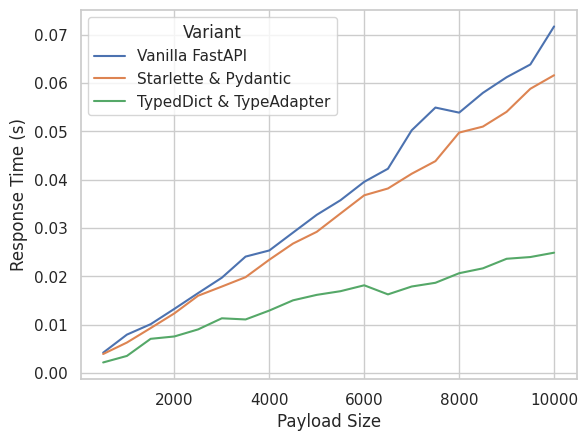

In [ ]:
#| code-fold: true

import seaborn as sns
sns.set_style("whitegrid")

data = pd.DataFrame(
    [(var, n, time) for (var, n), time in res.items()],
    columns=["Variant", "Payload Size", "Response Time (s)"]
)
data = data.replace({
    "fapi":"Vanilla FastAPI",
    "starl": "Starlette & Pydantic",
    "typdct": "TypedDict & TypeAdapter",
})

sns.lineplot(
    data=data,
    x="Payload Size",
    y="Response Time (s)",
    hue="Variant"
);

What does that tell us?  
We see that the `Starlette & Pydantic` optimization will reduce the processing time only by more or less a fix amount (at least for the tested range).
So the larger the input, the less impact of the optimization, i.e. the less it will pay off to refactor the code.  
On the other hand, the version `TypedDict & TypeAdapter` has really a different, better scaling relationship.
This means that such optimization will always pay off, since the larger payload, the larger absolute time save.  

Having said that, what I presented should simply be taken into account as an heuristic to search for optimizations in your code (only if you really need them!).
You have to benchmark your code to decide if any of this makes sense for your use case.

# 🤷 One last word: There's no free lunch
Unfortunately, by stripping away the custom type hints and using the plain classes `Request` (from Starlette) and `TypedDict+TypeAdapter`, we loose the information that FastAPI uses to generate the automatic documentation based on the openapi spec (do notice though that the data validation still works!).
It will be up to you to decide if you can live with that and/or the performance gain is worth it. 

Here's how this looks like (on the right is the version with all the optimizations):

<img align="center" src="../images/swagger.png"  style="height:35%;"/>

<div style="text-align: right; font-size: 40px; font-family: 'Inconsolata', monospace;">
  /Fin
</div>
    
<div style="font-family: 'Inconsolata', monospace;">
Any bugs, questions, comments, suggestions? Ping me on [twitter](https://www.twitter.com/fabridamicelli) or drop me an e-mail (fabridamicelli at gmail).  
Share this article on your favourite platform:
</div>